# 1. Import Libraries
 Kode ini mengimpor pustaka yang diperlukan untuk memproses data, membangun model CNN, dan melakukan evaluasi.

In [ ]:
# Mengimpor library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# SkincareSurveyData_10k.csv
!gdown --id 1AX4acCz4X-1NJiTQrDYDv3MQHCxdjJ3C

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AX4acCz4X-1NJiTQrDYDv3MQHCxdjJ3C
To: /content/SkincareSurveyData_10k.csv
100% 4.56M/4.56M [00:00<00:00, 54.1MB/s]


Load the dataset


In [ ]:
# Membaca dataset
data = pd.read_csv("SkincareSurveyData_10k.csv")

# Memeriksa beberapa baris pertama dari dataset
print(data.head())

         Timestamp  Gender    Age                     Race         Occupation  \
0   4/3/2022 14:26  Female     27                  African          Architect   
1   3/23/2022 7:19  Female  15-20                   Indian         Consultant   
2  11/19/2022 4:01  Female     34                   Korean            Manager   
3   11/9/2022 7:23    Male     29                   Korean  Software Engineer   
4  6/26/2022 18:07  Female  35-40  Bumiputra Sabah (Bajau)            Teacher   

  Do you agree that skincare is important ?  \
0                                       Yes   
1                                         5   
2                                         5   
3                                         4   
4                                       Yes   

  Have you ever used any skin care products?  \
0                                        Yes   
1                                        Yes   
2                                        Yes   
3                                     

In [ ]:
# Set parameter
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = 0.8

In [ ]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
def remove_stopwords(text, stopwords):
    for word in stopwords:
        text = text.replace(f" {word} ", " ")
    return text

labeling dataset


In [ ]:
def label_skin_type(sentence):
    """
    Fungsi untuk memberi label jenis kulit berdasarkan kata kunci yang diberikan.
    Prioritas:
    1. Kata kunci utama: "oily", "dry", "normal"
    2. Kondisi tambahan jika tidak ada kata kunci utama, atau ada lebih dari satu kategori utama
    """
    # Ubah kalimat menjadi huruf kecil untuk pencocokan kata
    sentence = sentence.lower()

    # Prioritas 1: Pencocokan langsung kata kunci utama
    is_oily = "oily" in sentence
    is_dry = "dry" in sentence
    is_normal = "normal" in sentence

    if is_oily and not (is_dry or is_normal):
        return "oily"
    elif is_dry and not (is_oily or is_normal):
        return "dry"
    elif is_normal and not (is_oily or is_dry):
        return "normal"

    # Prioritas 2: Jika tidak ada atau ada lebih dari satu kategori utama
    # Kata kunci tambahan untuk klasifikasi
    oily_keywords = ["acne", "breakout", "blackheads", "whiteheads", "clogged pores"]
    dry_keywords = ["dull", "eczema", "redness", "flaky"]

    # Periksa keberadaan kata kunci tambahan
    for word in oily_keywords:
        if word in sentence:
            return "oily"
    for word in dry_keywords:
        if word in sentence:
            return "dry"

    # Default jika tidak ada kecocokan
    return "normal"

# Mengaplikasikan fungsi untuk memberikan label ke dataset
data['Skin Type'] = data["Which, if any, of the following statements applies to you?"].apply(label_skin_type)

# Menampilkan beberapa baris pertama untuk memeriksa hasil labeling
print(data[["Which, if any, of the following statements applies to you?", "Skin Type"]].head())


  Which, if any, of the following statements applies to you? Skin Type
0  I have pigmentation;I have a combination skin ...            normal
1  I have sensitive skin;I have pigmentation;I st...              oily
2  I have pigmentation;I have dry and dull skin;I...               dry
3  I have pigmentation;I struggle with acne and b...              oily
4  I have oily skin;I struggle with acne and brea...              oily


## Prepare the dataset for training

In [ ]:
train_size = int(len(data) * training_portion)

train_sentences = data['Which, if any, of the following statements applies to you?'][:train_size]
train_labels = data['Skin Type'][:train_size]

validation_sentences = data['Which, if any, of the following statements applies to you?'][train_size:]
validation_labels = data['Skin Type'][train_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)  # Melatih tokenizer dengan data pelatihan

# Mengonversi kalimat menjadi sequence angka
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print("Train Padded Shape:", train_padded.shape)
print("Validation Padded Shape:", validation_padded.shape)

Train Padded Shape: (8000, 120)
Validation Padded Shape: (2000, 120)


In [ ]:
# Mengubah label kategori menjadi angka
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)

# Menampilkan beberapa contoh label yang telah dikodekan
print("Encoded Train Labels:", train_labels_encoded[:5])
print("Encoded Validation Labels:", validation_labels_encoded[:5])


Encoded Train Labels: [1 2 0 2 2]
Encoded Validation Labels: [1 2 1 1 0]


create the model

In [ ]:
def create_model(vocab_size, embedding_dim, max_length):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),  # Embedding layer
        layers.GlobalAveragePooling1D(),  # Pooling layer
        layers.Dense(24, activation='relu'),  # Dense hidden layer
        layers.Dense(3, activation='softmax')  # Output layer (3 kelas untuk jenis kulit)
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

    return model


In [ ]:
model = create_model(vocab_size=1000, embedding_dim=16, max_length=120)

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_10          │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

train & evaluate

In [ ]:
num_epochs = 30
history = model.fit(train_padded, train_labels_encoded,
                    epochs=num_epochs,  # Menentukan jumlah epoch
                    validation_data=(validation_padded, validation_labels_encoded))  # Data validasi

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3906 - loss: 1.0793 - val_accuracy: 0.4200 - val_loss: 1.0437
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4321 - loss: 1.0356 - val_accuracy: 0.4200 - val_loss: 1.0374
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4306 - loss: 1.0335 - val_accuracy: 0.4200 - val_loss: 1.0343
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4376 - loss: 1.0265 - val_accuracy: 0.4200 - val_loss: 1.0297
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4381 - loss: 1.0221 - val_accuracy: 0.4685 - val_loss: 1.0240
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4678 - loss: 1.0183 - val_accuracy: 0.4260 - val_loss: 1.0179
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5251 - loss: 1.0126 - val_accuracy: 0.6795 - val_loss: 1.0084
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6106 - loss: 0.9904 - val_accuracy: 0.

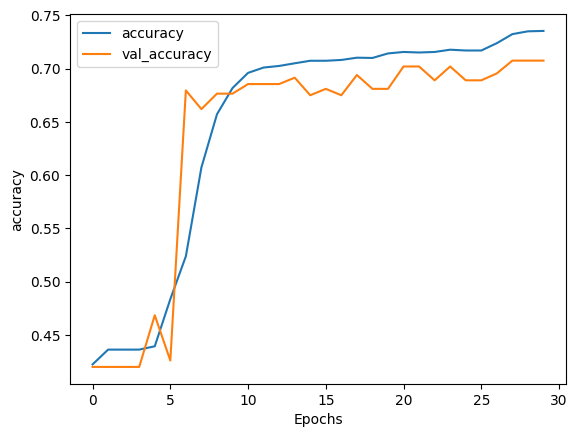

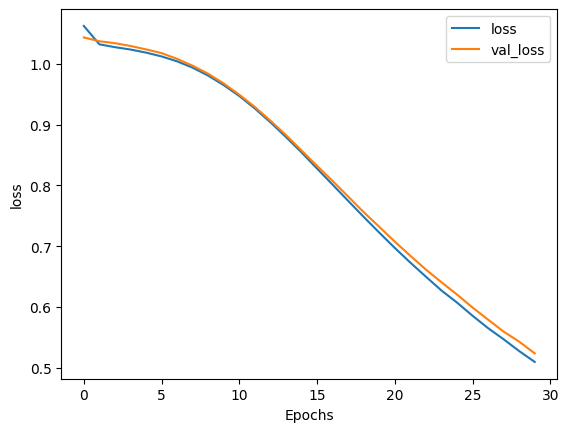

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

predict


In [ ]:
# Jawaban user yang akan diprediksi
test_sentences = [
    "I suffer from redness and sensitivity",
    "I have a combination skin with dry and oily places",
    "I have acne scars",
    "I have minor problem",
    "My skin feels dry and flaky",
    "I have red patches and sensitivity",
    "I have dry and dull skin",
    "I suffer from redness and sensitivity;I have brown spots from sun damages",
    "I have pigmentation;I struggle with acne and breakout"
]


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Inisialisasi Tokenizer dan fit pada data latih (misalnya X_train)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(validation_sentences)  # Gunakan data latih untuk fit tokenizer

# Tokenisasi dan padding data uji
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=100)  # Sesuaikan panjang input


In [ ]:
# Menggunakan model untuk prediksi
predictions = model.predict(test_padded)

# Mengonversi hasil prediksi menjadi kelas (misalnya, 0 = Oily, 1 = Dry, 2 = Normal)
predicted_classes = predictions.argmax(axis=1)

# Menampilkan hasil prediksi
for i, sentence in enumerate(test_sentences):
    print(f"Jawaban: {sentence}")
    print(f"Prediksi Jenis Kulit: {['Dry', 'Normal', 'Oily'][predicted_classes[i]]}")
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Jawaban: I suffer from redness and sensitivity
Prediksi Jenis Kulit: Dry
--------------------------------------------------
Jawaban: I have a combination skin with dry and oily places
Prediksi Jenis Kulit: Oily
--------------------------------------------------
Jawaban: I have acne scars
Prediksi Jenis Kulit: Oily
--------------------------------------------------
Jawaban: I have minor problem
Prediksi Jenis Kulit: Normal
--------------------------------------------------
Jawaban: My skin feels dry and flaky
Prediksi Jenis Kulit: Normal
--------------------------------------------------
Jawaban: I have red patches and sensitivity
Prediksi Jenis Kulit: Dry
--------------------------------------------------
Jawaban: I have dry and dull skin
Prediksi Jenis Kulit: Dry
--------------------------------------------------
Jawaban: I suffer from redness and sensitivity;I have brown spots from sun damages
Prediksi Jenis Kulit: Dry
---------------------------